In [118]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [119]:
import numpy as np
import pandas as pd

In [120]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [121]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [122]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [123]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [124]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [125]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [126]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

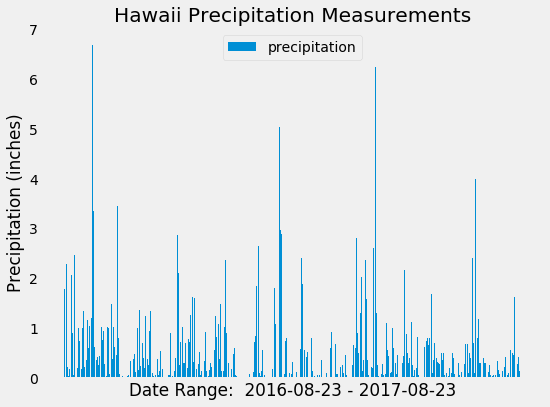

In [335]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date_q = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = dt.date(2017, 8, 23)

one_year_ago = last_date - dt.timedelta(days=365)

last_12 = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= one_year_ago)

# Save the query results as a Pandas DataFrame and set the index to the date column
stmt = last_12.statement
df = pd.read_sql_query(stmt, session.bind)
df.set_index('date', inplace=True)

# Sort the dataframe by date
df.sort_values(by=['date'])
df.head()

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(8,6))
plt.bar(df.index, df['prcp'])
plt.title("Hawaii Precipitation Measurements")
plt.ylabel("Precipitation (inches)")
plt.xlabel(f"Date Range:  {one_year_ago} - {last_date}")
#plt.xlabel("date")
plt.xticks([])
plt.grid()
plt.legend(["precipitation"], loc = 'upper center')
plt.show()



![precipitation](Images/precipitation.png)

In [128]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary = pd.DataFrame(df['prcp'].describe())
summary = summary.rename(columns = {'prcp': 'precipitation'})
summary

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [129]:
# Design a query to show how many stations are available in this dataset?
stations_available = session.query(func.count(Station.station)).all()
stations_available

[(9)]

In [130]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [131]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperatre recorded, and average temperature most active station?
most_active_temp = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()
most_active_temp


[(54.0, 85.0, 71.66378066378067)]

Text(0,0.5,'Frequency')

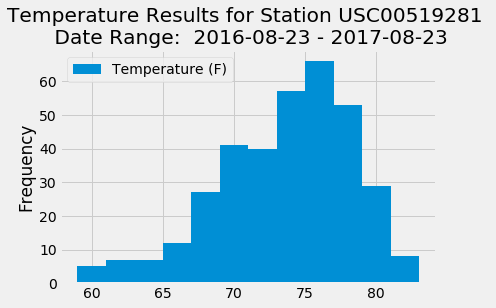

In [336]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station = session.query(Measurement).filter(Measurement.station == 'USC00519281').\
filter(Measurement.date >= one_year_ago)

stmt2 = most_active_station.statement
most_active_df = pd.read_sql_query(stmt2, session.bind)

plt.hist(most_active_df["tobs"], bins=12)

labels = ["Temperature (F)"]
plt.title(f"Temperature Results for Station USC00519281 \n Date Range:  {one_year_ago} - {last_date}")
plt.legend(labels)
plt.ylabel("Frequency")


In [133]:
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
date_tobs= session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= one_year_ago)
only_tobs = list(np.ravel(date_tobs))
only_tobs

![precipitation](Images/station-histogram.png)

In [134]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [135]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
previous_year_temps = calc_temps(one_year_ago, last_date)
print(previous_year_temps)


[(58.0, 74.59058295964125, 87.0)]


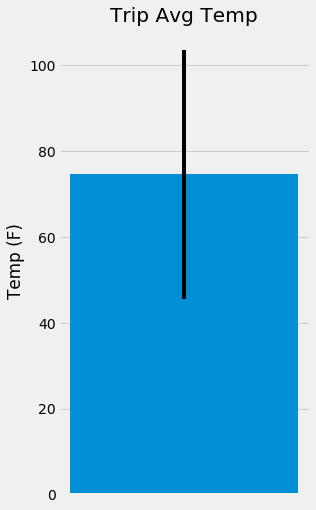

In [324]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmin = previous_year_temps[0][0] 
tavg = previous_year_temps[0][1] 
tmax = previous_year_temps[0][2] 

plt.figure(figsize=(4,8))
plt.bar(1, tavg, align="center", yerr=tmax-tmin)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.xticks([])
plt.show()


In [145]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall_station = session.query(func.sum(Measurement.prcp), Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation)\
    .join(Station, Measurement.station==Station.station)\
    .filter(Measurement.date >= one_year_ago)\
    .filter(Measurement.date <= last_date)\
    .group_by(Measurement.station)\
    .order_by(func.sum(Measurement.prcp).desc())

stmt3 = rainfall_station.statement
rainfall_df = pd.read_sql_query(stmt3, session.bind)
rainfall_df = rainfall_df.rename(columns = {"sum_1" : "total rainfall"})
rainfall_df


,total rainfall,station,name,latitude,longitude,elevation
0,147.81,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,70.03,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,48.51,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,38.01,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
4,33.24,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
5,16.09,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,4.59,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9


## Optional Challenge Assignment

In [201]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)
def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [250]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
start_date = '2011-03-01'
end_date = '2011-03-10'

# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
trip = session.query(func.strftime("%m-%d", Measurement.date))\
    .filter(Measurement.date >= start_date)\
    .filter(Measurement.date <= end_date)\
    .group_by(Measurement.date).all()
trip_dates = [t for t, in trip]
trip_dates
# Loop through the list of %m-%d strings and calculate the normals for each date
trip_normals = [daily_normals(day) for day in trip_dates]
trip_normals = [trip_normals for trip_normals, in trip_normals]
trip_normals


[(64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0),
 (60.0, 69.20338983050847, 76.0),
 (60.0, 69.17241379310344, 78.0),
 (59.0, 68.72413793103448, 78.0),
 (57.0, 68.56140350877193, 75.0),
 (57.0, 69.12280701754386, 75.0)]

In [251]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_df = pd.DataFrame(trip_normals, columns=['tmin', 'tavg', 'tmax'])
trip_df['date'] = trip_dates
trip_df.set_index('date', inplace=True)
trip_df

,tmin,tavg,tmax
date,,,
03-01,64.0,70.032787,76.0
03-02,61.0,70.366667,78.0
03-03,60.0,70.068966,78.0
03-04,57.0,69.272727,77.0
03-05,60.0,67.890909,76.0
03-06,60.0,69.203390,76.0
03-07,60.0,69.172414,78.0
03-08,59.0,68.724138,78.0
03-09,57.0,68.561404,75.0


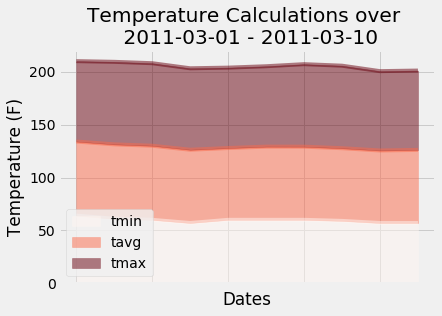

In [338]:
# Plot the daily normals as an area plot with `stacked=False`
# Use Pandas Plotting with Matplotlib to plot the data
trip_df.plot(kind='area', stacked='false', alpha=0.5, colormap='Reds')
plt.title(f"Temperature Calculations over \n {start_date} - {end_date}")
plt.ylabel("Temperature (F)")
plt.xlabel("Dates")
plt.legend(loc = 'lower left')
